In [5]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [4]:
pip install faiss-cpu

     |████████████████████████████████| 7.9MB 2.6MB/s 


In [6]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
#Trying to extract features for all type of image formats specified. We are getting numerical vectors for images.
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/content/drive/My Drive/images'
filenames = sorted(get_file_list(root_dir))

In [18]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [11]:
len(feature_list)
# Number of images

116

In [19]:
features=np.array(feature_list)
features.shape
#Number of features = 100352 for 116 images

(116, 100352)

In [20]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 5  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [22]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal) 

False
0
True
116


In [108]:
nprobe = 2  # find 2 most similar clusters
n_query = 1  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(feature_list[23].reshape(1,-1), k)

In [109]:
distances

array([[0.       , 1.2876729, 1.3377345, 1.4497929, 1.4531204, 1.4558387,
        1.4631231, 1.467625 , 1.4844854, 1.4867904]], dtype=float32)

In [110]:
indices #Similiar images indices

array([[23, 74, 73, 71, 12, 22, 10,  6, 18, 11]])

In [111]:
feature_list[1].reshape(1,-1).shape

(1, 100352)

In [112]:
list_ind=indices.flatten().tolist()

In [115]:
list_ind

[23, 74, 73, 71, 12, 22, 10, 6, 18, 11]

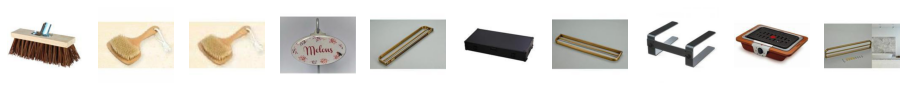

In [118]:
#Showing images
f, ax = plt.subplots(1, 10, figsize=(16, 8))
for i,j in enumerate(list_ind):
  ax[i].imshow(plt.imread(filenames[j]))
  ax[i].set_axis_off()

plt.show()
  #print(i)

In [23]:
# Building out function to implement FAISS :
def faiss_similarity(img):
  feature_list=extract_features('/content/drive/My Drive/images/'+str(img), model)
  nprobe = 2  # find 2 most similar clusters
  n_query = 1  
  print(feature_list)
  k = 10  # return 10 nearest neighbours
  np.random.seed(0)
  dimensions=len(feature_list)   
  query_vectors = np.random.random((n_query, dimensions)).astype('float32')
  distances, indices = index.search(feature_list.reshape(1,-1), k)
  list_ind=indices.flatten().tolist()
  f, ax = plt.subplots(1, 10, figsize=(16, 8))
  for i,j in enumerate(list_ind):
    ax[i].imshow(plt.imread(filenames[j]))
    ax[i].set_axis_off()
  plt.show()

[0. 0. 0. ... 0. 0. 0.]


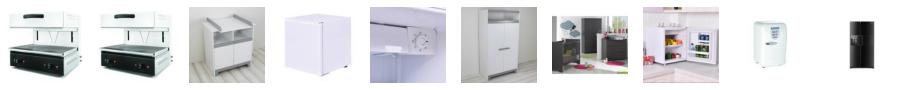

In [25]:
faiss_similarity('3615116_1.jpg')

[0. 0. 0. ... 0. 0. 0.]


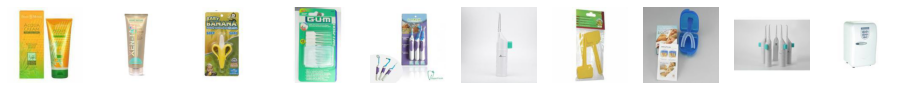

In [27]:
faiss_similarity('3693318_0.jpg')